In [2]:
from tqdm import tqdm
import pandas as pd
import glob
import pickle

from scipy.special import j0 as bessel_j0
import numpy as np
from matplotlib import pyplot as plt



In [11]:
distances = np.array([0.1]+[0.2]*98)

def transform_to_spatial_freq(r,R_r,k,dr=dr):
    res = 2 * np.pi * np.sum(r * bessel_j0(k*r) * R_r * distances) / 1000 / 1000
    return res


In [12]:
def calculate_real_frequencies_from_prepends(freq_prepends):
    """
    calculate real spatial frequencies k = 2pi/L from frequencies prepends
    """
    return 2*np.pi*np.array([x/160. for x in [float(x) for x in freq_prepends]])

In [13]:
freqs = np.array(['01','02','04','06','10','12','14','22','26','40','44'])
ks = calculate_real_frequencies_from_prepends(freqs)

In [16]:
def get_Rk(R_r, r, ks):
    R_k = []
    for k in ks:
        R_k.append(transform_to_spatial_freq(distances, R_r, k))
        
    return np.array(R_k)

In [17]:
with open('/2tb_drive/old_data/notebooks/Kirill/modeling_results35000.pkl','rb') as f:
    data = pickle.load(f)

In [18]:
df = pd.read_pickle('modeling_results_SFDI_11_ext.pkl')

Text(0, 0.5, 'Reflection coefficient')

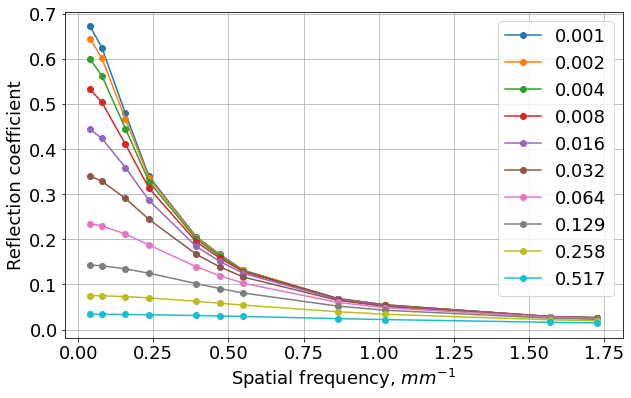

In [20]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
plt.figure(figsize=(10,6))

for i in range(1,20_000,2000):
    plt.plot(ks[:],df.R_k.iloc[i],'o-',
             label=f'{np.round(np.float64(df.iloc[i].mua),3)}')
    #plt.yscale('log')
plt.legend()
plt.grid()
plt.xlabel('Spatial frequency, $mm^{-1}$')
plt.ylabel('Reflection coefficient')

In [21]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [22]:
df_train, df_test = train_test_split(df, test_size=0.2)
X_train = df_train.R_k.apply(lambda x: x[::]).values
y_train = np.array(df_train[['mua']].values).astype(float)
X_train = np.array(list(X_train))


X_test = df_test.R_k.apply(lambda x: x[::]).values
y_test = np.array(df_test[['mua']].values).astype(float)
X_test = np.array(list(X_test))


In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(float)
X_test = scaler.transform(X_test).astype(float)

In [25]:
matplotlib.rcParams.update({'font.size': 25})

In [26]:
import sklearn.metrics as skmetrics

In [28]:
from torchvision import datasets
from torch.utils.data import Dataset
import torch
from torch.utils.data import DataLoader

In [29]:
cuda = torch.device('cuda')

In [41]:
from torchvision import datasets
class Dataset_mua(Dataset):
 
    def __init__(self,X,y,train=True):

        

        self.x_train = torch.tensor(X.astype(np.float32))

        self.y_train = torch.tensor(y.astype(np.float32))
        
    def __len__(self):
        return len(self.y_train)
   
    def __getitem__(self,idx):
        return self.x_train[idx],self.y_train[idx]

In [42]:
train = Dataset_mua(X_train,y_train)
test = Dataset_mua(X_test,y_test)
train_loader = DataLoader(train,batch_size=512,shuffle=True)
test_loader = DataLoader(test,batch_size=5120,shuffle=False)

In [43]:
import torch
import torch.nn.functional as F
from torch import nn
in_size=11
# define the network class
n=11

class FC(nn.Module):
    def __init__(self):
        # call constructor from superclass
        super().__init__()
        self.relu = nn.ReLU()
  

        self.fc1 = nn.Sequential(nn.Linear(in_size,n),nn.BatchNorm1d(n))
        self.fc2 = nn.Sequential(nn.Linear(n, n-2),nn.BatchNorm1d(n-2))
        self.fc3 = nn.Sequential(nn.Linear(n-2, n-4),nn.BatchNorm1d(n-4))
        self.fc4 = nn.Sequential(nn.Linear(n-4, n-6),nn.BatchNorm1d(n-6))
        self.fc5 = nn.Sequential(nn.Linear(n-6, n-8),nn.BatchNorm1d(n-8))
        self.fc6 = nn.Linear(n-8, 1)
        
    def forward(self, x):
        # define forward pass
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.fc6(x)

        return x
    

# instantiate the model
model = FC()


In [44]:
# define the network class
n=11

class FC(nn.Module):
    def __init__(self):
        # call constructor from superclass
        super().__init__()
        self.relu = nn.ReLU()
        # define network layers
        self.fc1 = nn.Sequential(nn.Linear(in_size,n),nn.BatchNorm1d(n))
        self.fc2 = nn.Sequential(nn.Linear(n, n),nn.BatchNorm1d(n))
       # self.fc3 = nn.Sequential(nn.Linear(n, n),nn.BatchNorm1d(n))
        #self.fc4 = nn.Sequential(nn.Linear(n, n),nn.BatchNorm1d(n))
        self.fc5 = nn.Sequential(nn.Linear(n, n),nn.BatchNorm1d(n))
        self.fc6 = nn.Linear(n, 1)
        
    def forward(self, x):
        # define forward pass
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
       # x = self.relu(self.fc3(x))
       # x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.fc6(x)

        return x
    

# instantiate the model
model = FC()

In [45]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')


In [47]:
for epoch in range(150):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        
    if epoch%10==0:
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss :.3f}')
    scheduler.step(running_loss)
    running_loss = 0.0

print('Finished Training')

[1,    55] loss: 0.079


KeyboardInterrupt: 

In [36]:
inputs, muas = next(iter(test_loader))   
list3, list4 = (list(t) for t in zip(*sorted(zip(muas[:,0].numpy(), model(inputs).detach().numpy()[:,0]))))

No handles with labels found to put in legend.


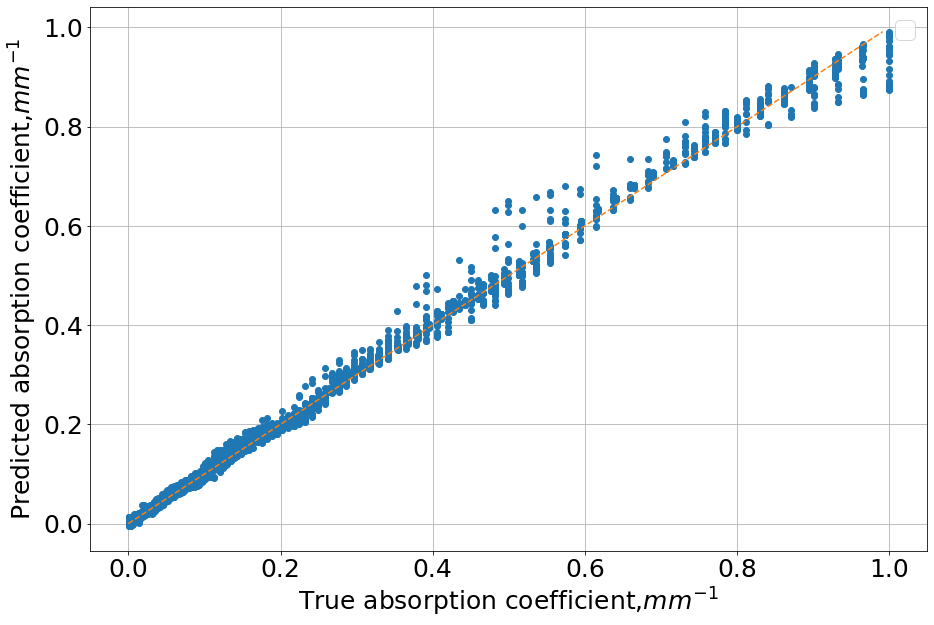

In [51]:
plt.figure(figsize=(15,10))


plt.plot(list3,list4,'o')
x = np.linspace(0,max(list4),100)
plt.plot(x,x,'--')
plt.xlabel('True absorption coefficient,$mm^{-1}$')
plt.ylabel('Predicted absorption coefficient,$mm^{-1}$')
plt.legend()
plt.grid()